In [ ]:
import numpy as np
import math
import random

In [ ]:
class Value():

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0
    self._backward = lambda: None  # by default we do nothing (for a leaf node there's nothing to do)
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __radd__(self, other): # other + self
    return self + other

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other):  # self * other
    return self * other

  def __truediv__(self, other):
    return self * other ** -1

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data ** other, (self, ), f'**{other}')

    def _backward():
      self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __sub__(self, other):
    return self + (-other)

  def __neg__(self):
    return self * -1

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t **2) * out.grad
    out._backward = _backward

    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)  # we add v only after all its children have been added

    build_topo(self)
    self.grad = 1.0

    for node in reversed(topo):
      node._backward()

In [ ]:
a = Value(1.0)
b = Value(2.0)
a / b

Value(data=0.5)

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label=n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)
  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)
  return dot

In [ ]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0
e.grad = -2.0
a.grad = 6.0
b.grad = -4.0

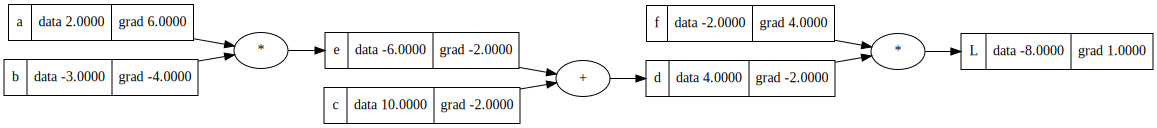

In [ ]:
draw_dot(L)

In [ ]:
a.data += 0.01*a.grad
b.data += 0.01*b.grad
c.data += 0.01*c.grad
f.data += 0.01*f.grad

e = a * b
d = e + c
L = d * f
print(L.data)

-6.586368000000001


In [ ]:
def lol():
  h = 1e-4
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label='d'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  e.data += h
  d = e + c; d.label='d'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1) / h)

lol()
  # d._prev
  # d._op

-1.9999999999953388


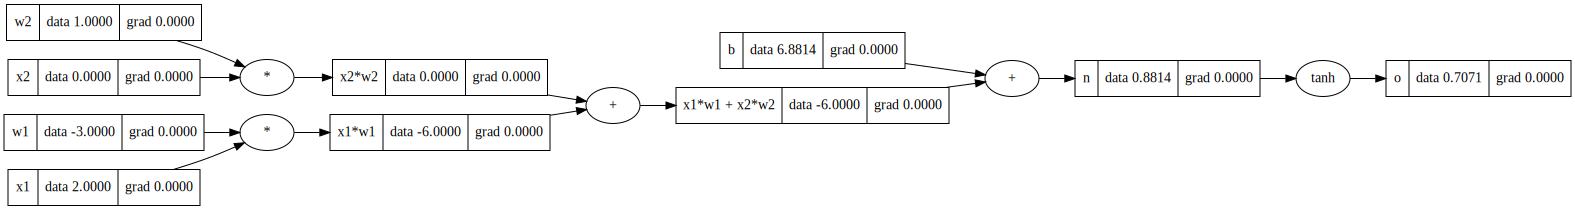

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights wl,w2
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
# bias of the neuron
b = Value(6.8813735870195432,label='b')
# X1*w1+X2*w2+b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label ='n'
o = n.tanh(); o.label = 'o'

draw_dot(o)

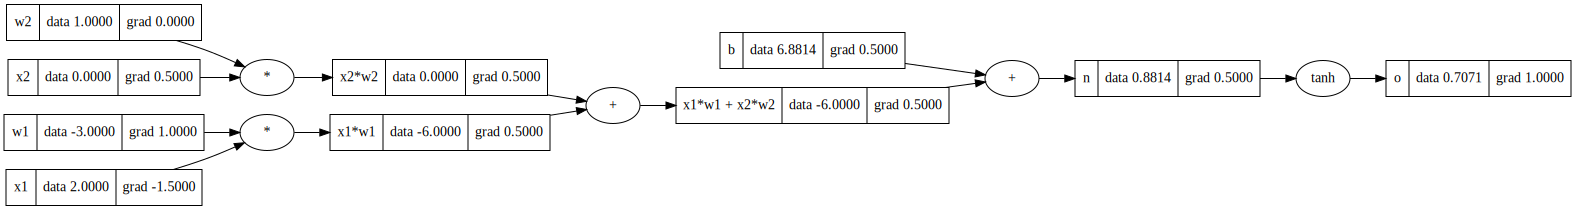

In [ ]:
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
x2._backward()
w2._backward()
x1._backward()
w1._backward()
draw_dot(o)

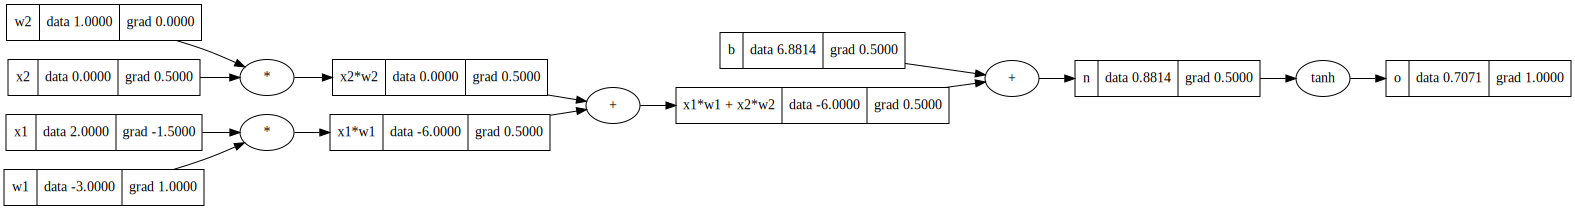

In [ ]:
o.grad = 1.0

# o = tanh(n)
# do/dn 1 - tanh(n)**2 = 1 - o**2
n.grad = 1 - o.data ** 2

x1w1x2w2.grad = 0.5
b.grad = 0.5

x1w1.grad = 0.5
x2w2.grad = 0.5

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

draw_dot(o)


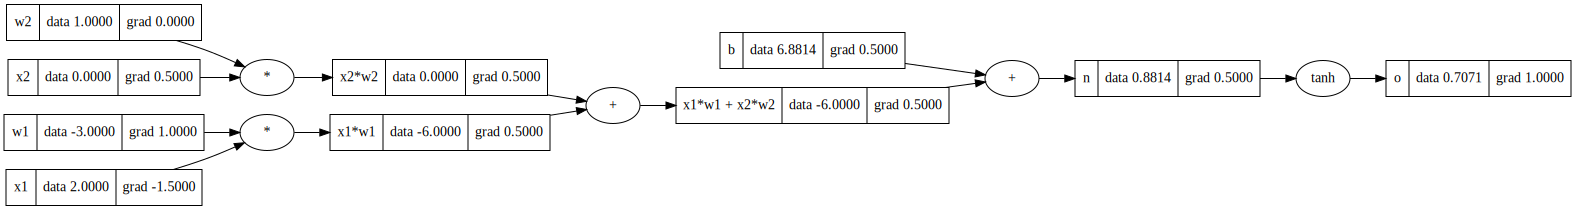

In [ ]:
o.backward()
draw_dot(o)

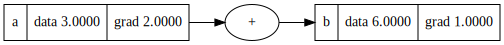

In [ ]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

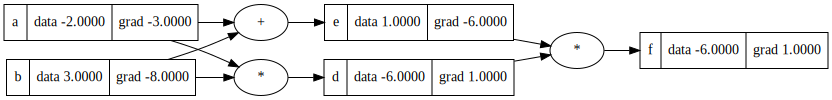

In [ ]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label='d'
e = a + b; e.label='e'
f = d * e; f.label='f'
f.backward()
draw_dot(f)

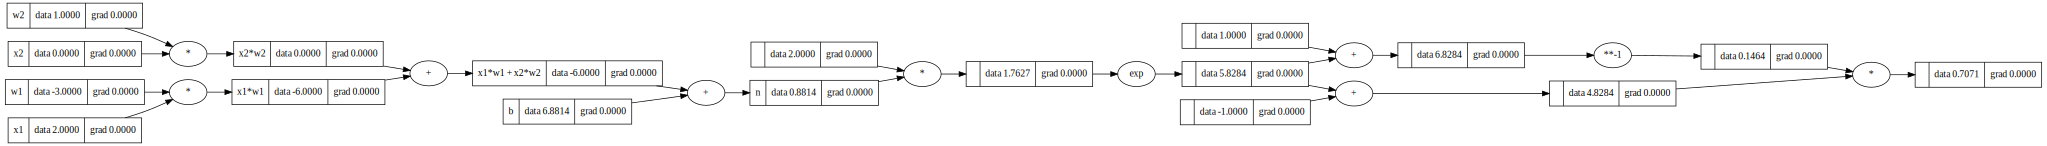

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights wl,w2
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
# bias of the neuron
b = Value(6.8813735870195432,label='b')
# X1*w1+X2*w2+b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label ='n'
# o = n.tanh(); o.label = 'o'
e = (2*n).exp()
o = (e-1) / (e+1)
draw_dot(o)

In [ ]:
class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]
    # params = []
    # for neuron in self.neurons:
    #   ps = neuron.parameters()
    #   params.extend(ps)
    # return params

class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)


Value(data=0.8705762835375856)

In [ ]:
n.parameters()

[Value(data=0.8698771316034108),
 Value(data=0.34733436403522777),
 Value(data=0.4454843504381132),
 Value(data=-0.6789787632856881),
 Value(data=-0.9713385309436726),
 Value(data=0.8920706868959953),
 Value(data=0.35354296102030536),
 Value(data=0.5284723052877072),
 Value(data=-0.8488853750014915),
 Value(data=0.81414746328093),
 Value(data=0.4507675919994929),
 Value(data=0.02224578121934795),
 Value(data=-0.949594845564746),
 Value(data=-0.1344206856758412),
 Value(data=-0.2107986829568096),
 Value(data=0.42600347127548766),
 Value(data=-0.5282864729395624),
 Value(data=-0.03258157058796285),
 Value(data=-0.05606127964561569),
 Value(data=-0.37615375269373774),
 Value(data=0.26265181743245325),
 Value(data=0.5607371542436128),
 Value(data=0.07666691675370862),
 Value(data=-0.7935916340931211),
 Value(data=0.2334610849416141),
 Value(data=-0.3067081396711411),
 Value(data=0.9560149897286758),
 Value(data=0.22209449143409676),
 Value(data=-0.9082295904648221),
 Value(data=-0.90722270

In [ ]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]  # desired targets

ypred = [n(x) for x in xs]
ypred

[Value(data=0.8705762835375856),
 Value(data=0.17003365853757305),
 Value(data=0.4532420125377331),
 Value(data=0.9187870348452327)]

In [ ]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=3.779487849562417)

In [ ]:
n.layers[0].neurons[0].w[0].grad

0

In [ ]:
loss.backward()

In [ ]:
n.layers[0].neurons[0].w[0].grad

0.0008858167271975637

In [ ]:
n.layers[0].neurons[0].w[0].data

0.8698771316034108

In [ ]:
for p in n.parameters():
  p.data -= 0.01 * p.grad

In [ ]:
n.layers[0].neurons[0].w[0].data

0.8698682734361388

In [ ]:
print(loss)
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
print(loss)

Value(data=3.779487849562417)
Value(data=3.715570408725996)


In [ ]:
for k in range(20):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0
  loss.backward()

  # update
  for p in n.parameters():
    p.data -= 0.05 * p.grad

  print(k, loss.data)

0 3.504237153207711
1 0.7256383416880184
2 0.40938667703998777
3 0.1673610313167528
4 0.11794654624472427
5 0.0942352118221215
6 0.0797038814165549
7 0.06958096823259186
8 0.06196910493456548
9 0.05595858928380523
10 0.051052410908029165
11 0.046951355473614884
12 0.04346154107765444
13 0.04045007724658676
14 0.03782184307830362
15 0.035506404014775075
16 0.03345017805384193
17 0.03161150110425835
18 0.02995738439752909
19 0.028461307224624425


In [ ]:
ypred

[Value(data=0.915176924725677),
 Value(data=-0.9421690823207295),
 Value(data=-0.8801596517798086),
 Value(data=0.9403323452407616)]

In [ ]:
ys

[1.0, -1.0, -1.0, 1.0]